# Analyse the future resident population

AIM: now that I have the projected population by age group till 2100, make some plots to understand how the future population will look like

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors as pc
import plotly.io as pio
from pandas_datareader import wb # https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#world-bank Italian data are probably copied from ISTAT anyway
from copy import deepcopy
import warnings

pio.renderers.default = 'vscode+notebook'
pd.options.plotting.backend = "plotly"
warnings.filterwarnings("ignore", category=FutureWarning)

def get_colors(n, cmap_name="rainbow"):
    """Get colors for px colors_discrete argument, given the number of colors needed, n."""
    cmap = matplotlib.colormaps[cmap_name]
    colors = [cmap(i) for i in np.linspace(0, 1, n)]  # Generate colors
    colors_str = [f"rgba({int(color[0]*250)}, {int(color[1]*250)}, {int(color[2]*250)}, 1.0)" for color in colors]
    return colors_str

# convert default plotly colors to matplotlib
plotly_colors = pc.qualitative.Plotly
matplotlib_colors = []
for color in plotly_colors:
    r, g, b = pc.hex_to_rgb(color)
    matplotlib_colors.append((r/255, g/255, b/255))

In [2]:
# Recover data from previous notebooks
dfp=pd.read_csv("../data/pop_by_age_year.csv", index_col=0).rename(columns=int)
dfpj_long_all = pd.read_csv("../data/pop_by_age_year_proj.csv")

In [3]:
start_year = dfp.columns[0] # 2002
last_year = dfp.columns[-1] # 2023 (or later if updated)
end_year = 2100

print(f"First-last observation: Jan/{start_year} - Jan/{last_year}")
print(f"First-last prediction:  Jan/{last_year+1} - Jan/{end_year}")

scenarios = [ col for col in dfpj_long_all.columns if col.startswith("mig") ]
print("\nScenarios:")
display(scenarios)

First-last observation: Jan/2002 - Jan/2024
First-last prediction:  Jan/2025 - Jan/2100

Scenarios:


['migr double  & fert ↑ 2 in 2024',
 'migr double  & fert eq. to last',
 'migr double  & fert ↓ 0 in 2024',
 'migr average & fert ↑ 2 in 2024',
 'migr average & fert eq. to last',
 'migr average & fert ↓ 0 in 2024',
 'migr zero    & fert ↑ 2 in 2024',
 'migr zero    & fert eq. to last',
 'migr zero    & fert ↓ 0 in 2024']

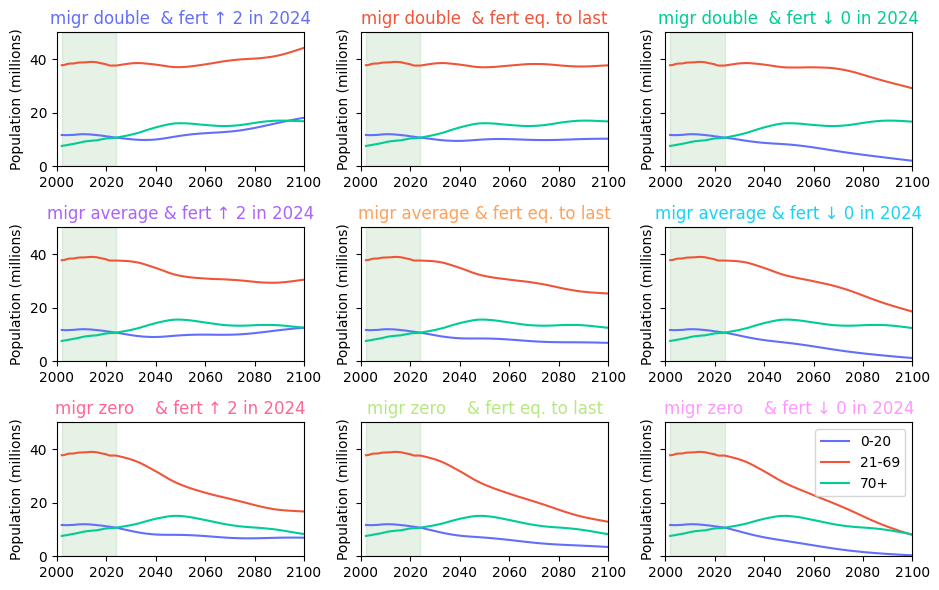

In [4]:
 # Create 3x3 subplots to show the population by age group (young, adult, senior) in each scenario
AGE1, AGE2 = 20, 70

df_plot = dfpj_long_all.melt(
    id_vars=["year", "age"], 
    value_vars=dfpj_long_all.columns[2:],
    var_name="scenario",
    value_name="population"
)

fig, axes = plt.subplots(3, 3, figsize=(9.5, 6), sharex=False, sharey=True)
for idx, scenario in enumerate(scenarios):
    
    ax = axes[idx // 3, idx % 3]
    df_scenario = df_plot[df_plot["scenario"] == scenario].copy()
    
    sum10 = df_scenario[df_scenario["age"].between(0, AGE1, inclusive='both')].groupby("year")["population"].sum()
    sum12 = df_scenario[df_scenario["age"].between(AGE1+1, AGE2-1, inclusive='both')].groupby("year")["population"].sum()
    sum23 =df_scenario[df_scenario["age"].between(AGE2, 100, inclusive='both')].groupby("year")["population"].sum()
    
    ax.plot(sum10.index, sum10.values/1e6, label=f"0-{AGE1}", color=matplotlib_colors[0])
    ax.plot(sum12.index, sum12.values/1e6, label=f"{AGE1+1}-{AGE2-1}", color=matplotlib_colors[1])
    ax.plot(sum23.index, sum23.values/1e6, label=f"{AGE2}+", color=matplotlib_colors[2])

    ax.set_title(scenario, color=matplotlib_colors[idx])
    ax.set_xlabel(None)
    ax.set_ylabel("Population (millions)")
    ax.set_xlim(2000, end_year)
    ax.set_ylim(0, 50)
    if idx == 8:
        ax.legend()
    ax.axvspan(start_year, last_year, color="green", alpha=0.1)

plt.tight_layout()
plt.savefig("../images_output/pop_by_age_proj_groups.png", dpi=200)
plt.show()

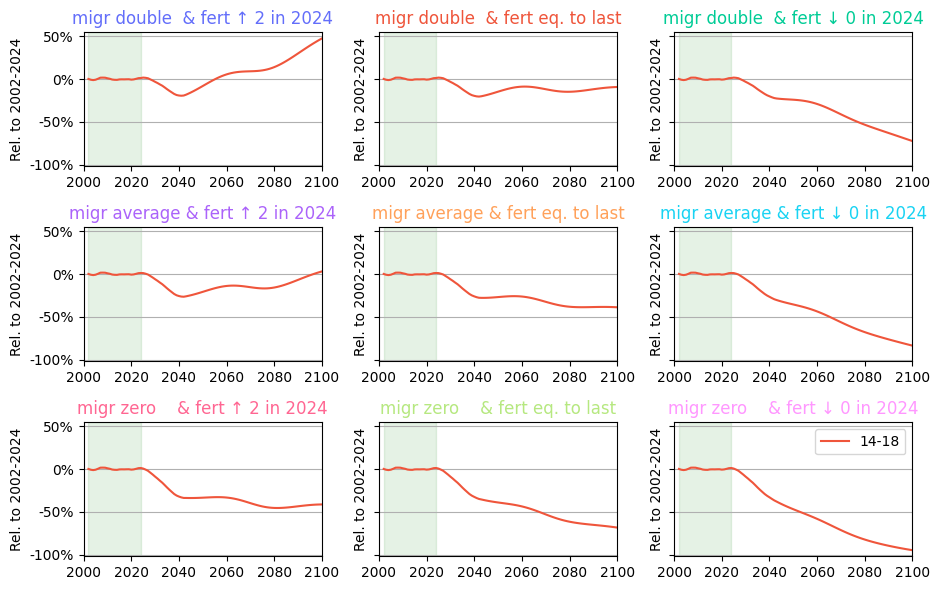

In [ ]:
AGE1, AGE2 = 14, 18

df_plot = dfpj_long_all.melt(
    id_vars=["year", "age"], 
    value_vars=dfpj_long_all.columns[2:],
    var_name="scenario",
    value_name="population"
)

fig, axes = plt.subplots(3, 3, figsize=(9.5, 6), sharex=False, sharey=True)
for idx, scenario in enumerate(scenarios):
    
    ax = axes[idx // 3, idx % 3]
    df_scenario = df_plot[df_plot["scenario"] == scenario].copy()
    
    sum12 = df_scenario[df_scenario["age"].between(AGE1, AGE2, inclusive='both')].groupby("year")["population"].sum()
    avg_past = sum12[sum12.index <= last_year].mean()
    
    ax.plot(sum12.index, sum12.values/avg_past - 1, label=f"{AGE1}-{AGE2}", color=matplotlib_colors[1])

    ax.set_title(scenario, color=matplotlib_colors[idx])
    ax.set_xlabel(None)
    ax.set_ylabel(f"Rel. to {start_year}-{last_year}")
    ax.set_xlim(2000, end_year)
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.0%}"))
    if idx == 8:
        ax.legend()
    ax.axvspan(start_year, last_year, color="green", alpha=0.1)
    ax.grid(axis='y')

plt.tight_layout()
#plt.savefig("../images_output/pop_by_age_proj_groups.png", dpi=200)
plt.show()

In [6]:
# Values from previous analysis on fertility (see Notebook #40)
LAST_OBSERVERD_FERTILITY_YEAR = 2023
LAST_OBSERVED_FERTILITY_VALUE = 1.17
SIGMOID_X0_M = 9.45830775e-02
SIGMOID_X0_Q = -1.59900266e+02
SIGMOID_K = -0.295516663172129
WOMEN_POP_RATIO = 0.5 

def get_newborns_next_year(dfp, year, fertility_rate):
    """Fom population and fertility rate for a given year,
    get the number of newborns for the NEXT year (fist January of year+1)."""
    def constrained_sigmoid(x0, k):
        """Get sigmoid function, which is a cumsum of a distribution."""
        x = np.arange(17, 50+1)
        y = 1 / (1 + np.exp(-k * (x - x0)))
        y = y - y[0]
        y = y / y[-1]
        return y
    pop = dfp[year]
    mothers_potential = pop.loc[18:50].to_numpy() * WOMEN_POP_RATIO
    x0 = np.polyval([ SIGMOID_X0_M, SIGMOID_X0_Q], year)
    distrib = np.diff(constrained_sigmoid(x0, SIGMOID_K))
    #print(mothers_potential*distrib)
    return sum(mothers_potential * distrib) * fertility_rate

fertility_rate = {}
m_coeff_scenario_1 = (2 - LAST_OBSERVED_FERTILITY_VALUE) / (end_year - LAST_OBSERVERD_FERTILITY_YEAR)
m_coeff_scenario_3 = (0 - LAST_OBSERVED_FERTILITY_VALUE) / (end_year - LAST_OBSERVERD_FERTILITY_YEAR)
for year in range(LAST_OBSERVERD_FERTILITY_YEAR, end_year+1):
    fertility_rate[year] = {
        f"↑ 2 in {last_year}": LAST_OBSERVED_FERTILITY_VALUE + m_coeff_scenario_1 * (year - LAST_OBSERVERD_FERTILITY_YEAR), # going to 2
        "eq. to last": LAST_OBSERVED_FERTILITY_VALUE, # constant
        f"↓ 0 in {last_year}": LAST_OBSERVED_FERTILITY_VALUE + m_coeff_scenario_3 * (year - LAST_OBSERVERD_FERTILITY_YEAR), # going to 0
    }